# MetroInsight Data Exploration and Analysis

In [1]:
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.tsa.ar_model
import sklearn.linear_model

%matplotlib inline
plt.rcParams['figure.max_open_warning'] = 0

data_dir = 'data/'

### Building Depot Data Plots

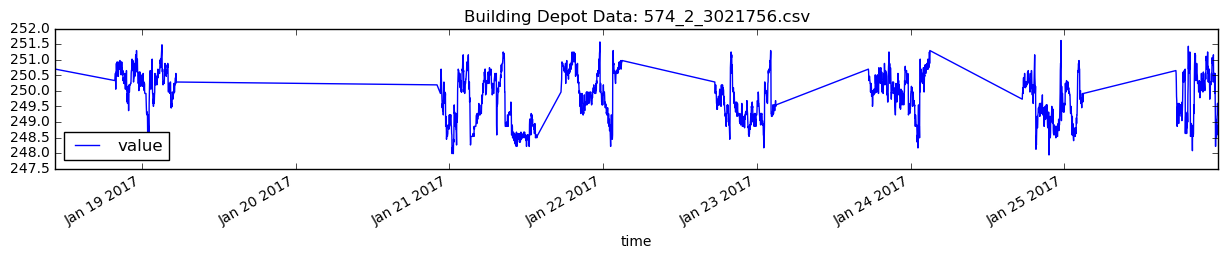

In [2]:
df = pd.read_csv(data_dir + 'buildingdepot/data/574_2_3021756.csv')
df['time'] = pd.to_datetime(df['time'])

df.plot(x='time', y='value', figsize=(15, 2))
plt.title('Building Depot Data: 574_2_3021756.csv')

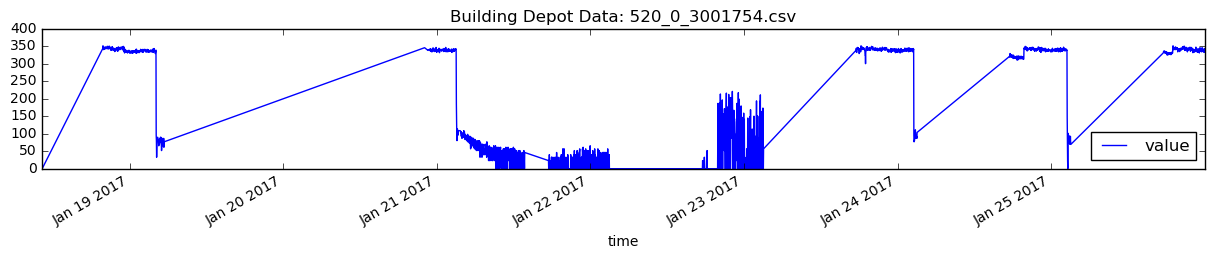

In [3]:
df = pd.read_csv(data_dir + 'buildingdepot/data/520_0_3001754.csv')
df['time'] = pd.to_datetime(df['time'])

df.plot(x='time', y='value', figsize=(15, 2))
plt.title('Building Depot Data: 520_0_3001754.csv')

### ION Data Plots

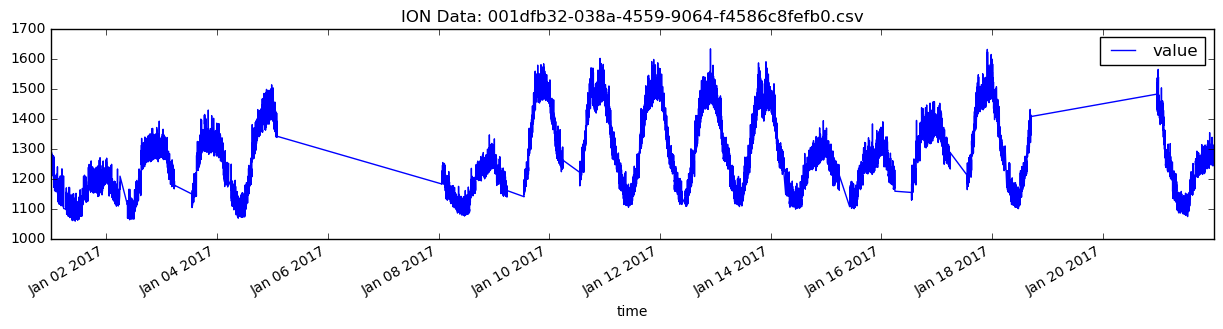

In [4]:
df = pd.read_csv(data_dir + 'ion_data/data/001dfb32-038a-4559-9064-f4586c8fefb0.csv',
                header=None, names=['time', 'value'])
df['time'] = pd.to_datetime(df['time'])

df.plot(x='time', y='value', figsize=(15, 3))
plt.title('ION Data: 001dfb32-038a-4559-9064-f4586c8fefb0.csv')

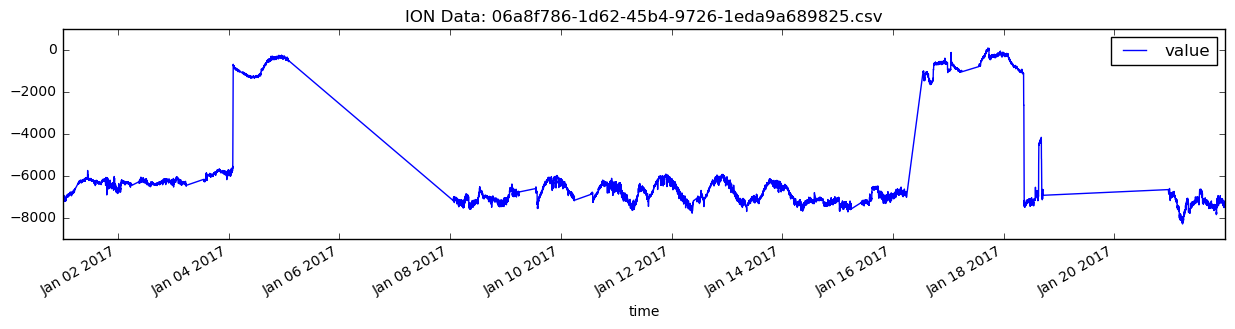

In [5]:
df = pd.read_csv(data_dir + 'ion_data/data/06a8f786-1d62-45b4-9726-1eda9a689825.csv',
                header=None, names=['time', 'value'])
df['time'] = pd.to_datetime(df['time'])

df.plot(x='time', y='value', figsize=(15, 3))
plt.title('ION Data: 06a8f786-1d62-45b4-9726-1eda9a689825.csv')

### Google Traffic Data Plots

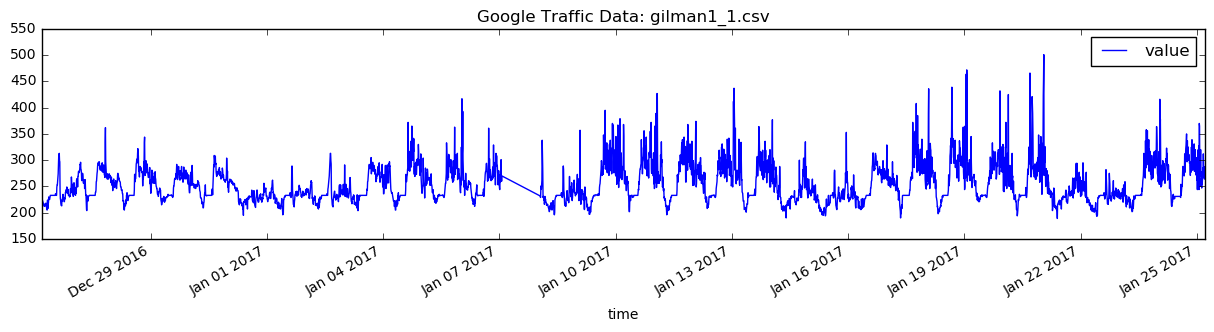

In [6]:
df = pd.read_csv(data_dir + 'google_traffic/data/gilman1_1.csv',
                header=None, names=['time', 'value'])
df['time'] = pd.to_datetime(df['time'])

df.plot(x='time', y='value', figsize=(15, 3))
plt.title('Google Traffic Data: gilman1_1.csv')

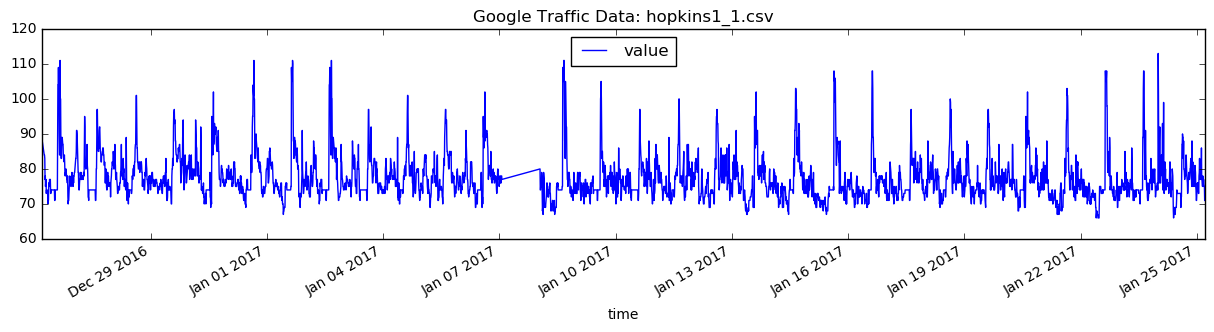

In [7]:
df = pd.read_csv(data_dir + 'google_traffic/data/hopkins1_1.csv',
                header=None, names=['time', 'value'])
df['time'] = pd.to_datetime(df['time'])

df.plot(x='time', y='value', figsize=(15, 3))
plt.title('Google Traffic Data: hopkins1_1.csv')

### Autoregression Model
- Predict future travel times on Google Traffic data.

RMSE: 19.4329029292


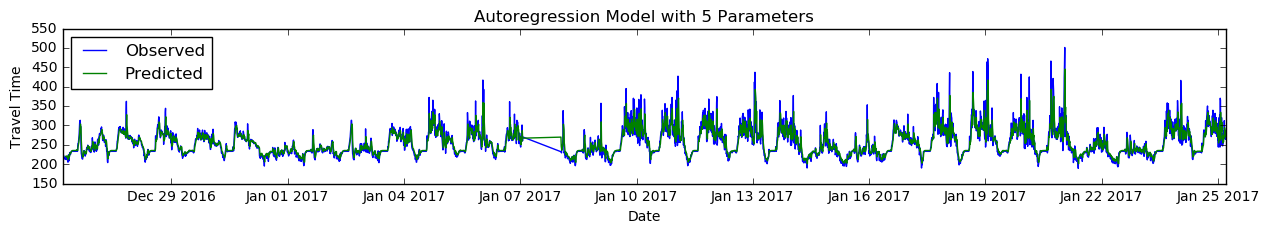

In [8]:
# Train an Autoregression model using the Statsmodels library
df = pd.read_csv(data_dir + 'google_traffic/data/gilman1_1.csv',
                header=None, names=['time', 'value'])
df['time'] = pd.to_datetime(df['time'])
df = df.set_index('time')

ar_mod = statsmodels.tsa.ar_model.AR(df['value']).fit(maxlag=5)
errors = df['value'] - ar_mod.fittedvalues
rmse = np.sqrt(errors.pow(2).mean())
print 'RMSE: ' + str(rmse)

plt.figure(figsize=(15, 2))
plt.plot(df['value'], label='Observed')
plt.plot(ar_mod.fittedvalues, label='Predicted')
plt.title('Autoregression Model with 5 Parameters')
plt.xlabel('Date')
plt.ylabel('Travel Time')
plt.legend(loc='best')

### Autoregression Model with Weather Data
- Try introducing hourly weather features and compare performance.

In [9]:
# Read and process historical San Diego weather data
weather_files = sorted(glob.glob(data_dir + 'google_traffic/weather_data/*.csv'))
weather_frames = []
for filename in weather_files:
    hourly_df = pd.read_csv(filename)
    hourly_df['DateUTC'] = pd.to_datetime(hourly_df['DateUTC'])
    weather_frames.append(hourly_df)
    
weather_df = pd.concat(weather_frames, ignore_index=True)
weather_df = weather_df.set_index('DateUTC')
weather_df = weather_df.fillna({'PrecipitationIn': 0})
weather_df.loc[weather_df['Wind SpeedMPH'] == 'Calm', 'Wind SpeedMPH'] = 0
weather_df['Wind SpeedMPH'] = weather_df['Wind SpeedMPH'].astype(float)
weather_df = weather_df.drop(['TimePST', 'Dew PointF', 'Humidity', 'Sea Level PressureIn',
                              'VisibilityMPH', 'Wind Direction', 'Gust SpeedMPH', 'Events',
                              'Conditions', 'WindDirDegrees'], axis=1)

In [10]:
# Join Google Traffic and Weather Underground data
nearest_indices = np.searchsorted(weather_df.index, df.index)
df['WeatherIdx'] = weather_df.index.get_values()[nearest_indices]
merged = pd.merge(df, weather_df, left_on='WeatherIdx', right_index=True)
merged = merged.drop(['WeatherIdx'], axis=1)
df = df.drop(['WeatherIdx'], axis=1)

RMSE: 19.3735862453


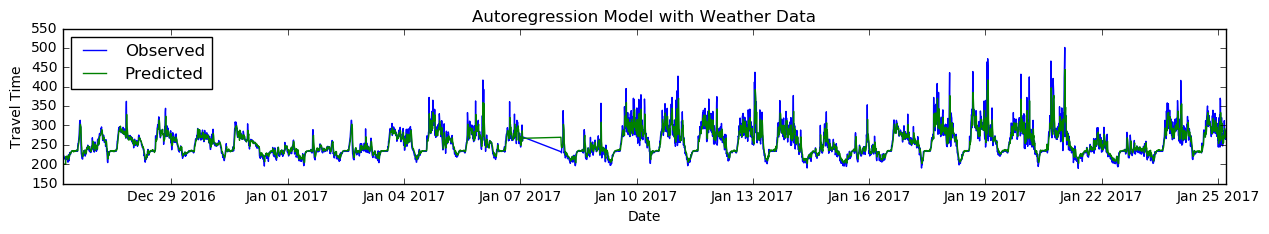

In [11]:
# Train Autoregression model using weather features
order = 5

X = []
y = []

for i in range(order, len(merged)):
    example = merged['value'].values[i-order:i]
    example = np.concatenate((example, merged['TemperatureF'].values[i-order:i]))
    example = np.concatenate((example, merged['Wind SpeedMPH'].values[i-order:i]))
    example = np.concatenate((example, merged['PrecipitationIn'].values[i-order:i]))
    example = np.insert(example, 0, 1, axis=0)  # Add bias term
    X.append(example)
    y.append(merged['value'].values[i])

X = np.vstack(X).astype(np.float32)
y = np.array(y).astype(np.float32)
y = np.reshape(y, (len(y), 1))

model = sklearn.linear_model.LinearRegression()
model.fit(X, y)
rmse = np.sqrt(np.mean((model.predict(X) - y)**2))
print 'RMSE: ' + str(rmse)

merged['predictions'] = np.pad(model.predict(X), ((5, 0), (0, 0)), 'constant', constant_values=200)
plt.figure(figsize=(15, 2))
plt.plot(merged['value'], label='Observed')
plt.plot(merged['predictions'], label='Predicted')
plt.title('Autoregression Model with Weather Data')
plt.xlabel('Date')
plt.ylabel('Travel Time')
plt.legend(loc='best')

### Autoregression Model using ION Datasets
- Try to predict Google Traffic travel time based on ION sensor values
- Use Lasso regression to extract only those sensors which are the most predictive of travel times.

In [12]:
# Read and process ION data files
ion_files = sorted(glob.glob(data_dir + 'ion_data/data/*.csv'))
ion_frames = []
for i in range(len(ion_files)):
    ion_df = pd.read_csv(ion_files[i], header=None, names=['time', 'value_' + str(i)])
    ion_df['time'] = pd.to_datetime(ion_df['time'])
    ion_df = ion_df.set_index('time')
    ion_frames.append(ion_df)
    
for ion_df in ion_frames:
    indices = np.searchsorted(ion_df.index, df.index)
    indices[indices == len(ion_df)] = len(ion_df) - 1
    df['ion_indices'] = ion_df.index.get_values()[indices]
    df = pd.merge(df, ion_df, left_on='ion_indices', right_index=True)

RMSE: 27.9922160783
Number of nonzero features: 25


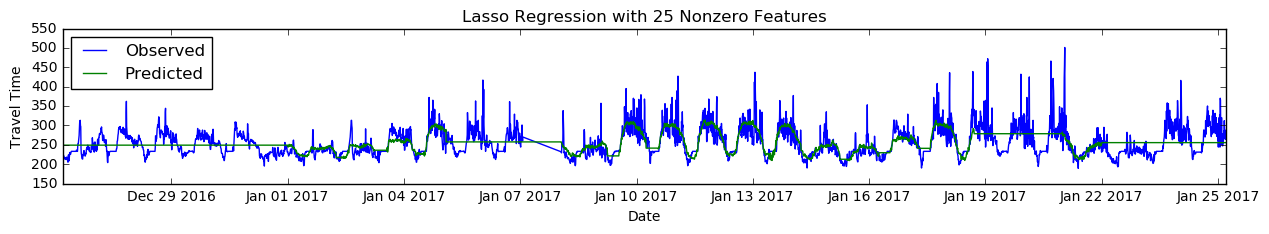

In [15]:
# Train a Lasso Regression model and display the results
ion_cols = ['value_' + str(i) for i in range(len(ion_frames))]
X = df[ion_cols].values
y = df['value'].values

clf = sklearn.linear_model.Lasso(alpha=50)
clf.fit(X, y)
rmse = np.sqrt(np.mean((clf.predict(X) - y)**2))
print 'RMSE: ' + str(rmse)

num_nonzero = sum([1 for i in clf.coef_ if i != 0.0])
print 'Number of nonzero features: ' + str(num_nonzero)

plt.figure(figsize=(15, 2))
plt.plot(pd.DataFrame(y, index=df.index[:len(y)]), label='Observed')
plt.plot(pd.DataFrame(clf.predict(X), index=df.index[:len(y)]), label='Predicted')
plt.title('Lasso Regression with ' + str(num_nonzero) + ' Nonzero Features')
plt.xlabel('Date')
plt.ylabel('Travel Time')
plt.legend(loc='best')

data/ion_data/data/00ca54b9-1eb9-45e8-b93d-ddf4f38c91c7.csv
data/ion_data/data/11ba5871-bc34-4cca-8f3f-9c99914ed94e.csv
data/ion_data/data/43ff3d0c-9297-43a2-b13e-8bf4c4bec83c.csv
data/ion_data/data/49c9a442-4917-4db1-9033-3b39daf6aacb.csv
data/ion_data/data/4eeee7eb-b5d1-420e-8e7a-63b6b28f24bd.csv
data/ion_data/data/4ff2e9d9-d1f4-429a-bb91-89c75ce5ed11.csv
data/ion_data/data/52a85b66-8686-47f7-b2c0-b8a10af47d54.csv
data/ion_data/data/58d35626-4353-4ad4-948e-7c3dedd23d29.csv
data/ion_data/data/62d25c24-c0ca-4b2f-a69e-167d85244c02.csv
data/ion_data/data/66833259-fcca-4cea-b289-587758eed832.csv
data/ion_data/data/69d92b7e-a665-4002-844e-08b105e77add.csv
data/ion_data/data/6aeb05a2-bb7c-433e-ab98-846117a9c401.csv
data/ion_data/data/82cf6112-8e12-49b2-a75f-ad8ef7e0c4ff.csv
data/ion_data/data/8d4a7542-3d1e-4ca1-a947-62f65adbd9d8.csv
data/ion_data/data/91e49ecd-d43a-48de-b52b-342858f2a081.csv
data/ion_data/data/9d1f8a44-1b9b-4660-a38a-990ea6a8ff0c.csv
data/ion_data/data/a1974e79-33e6-4c20-88

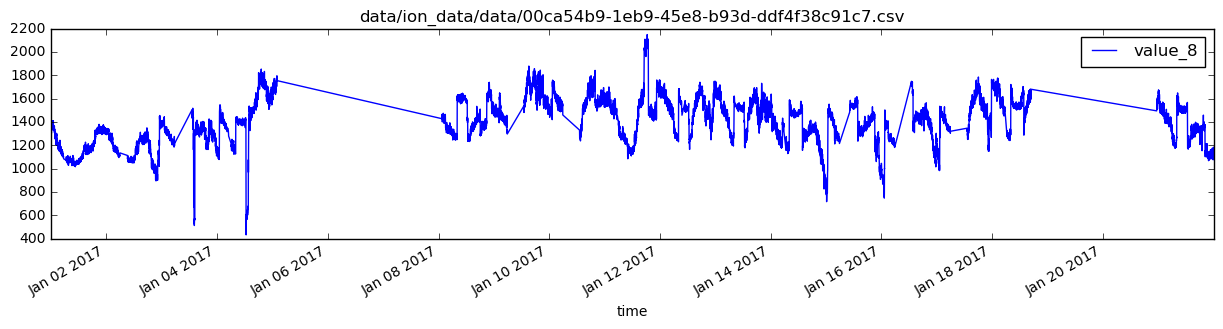

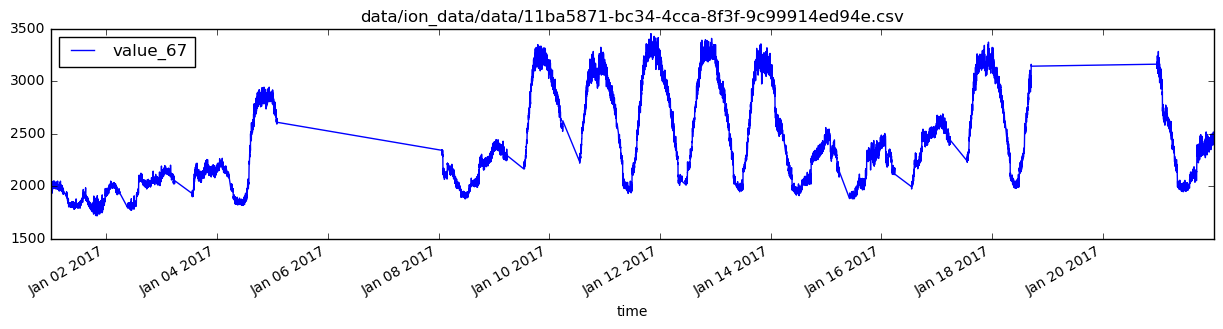

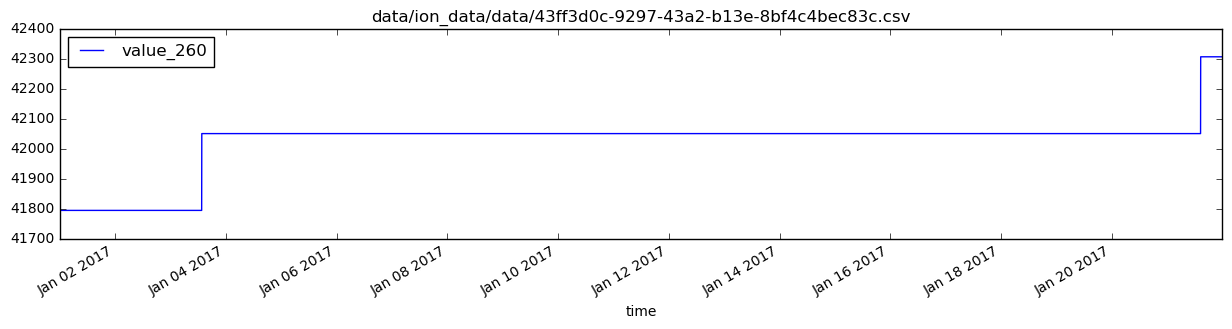

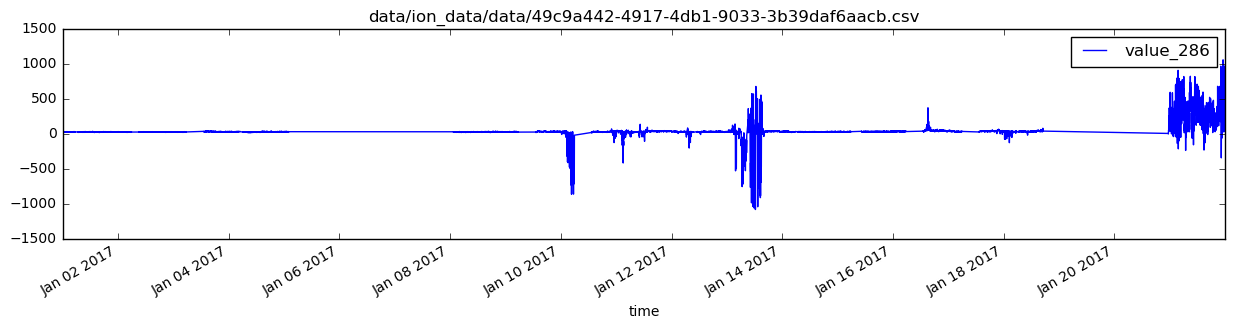

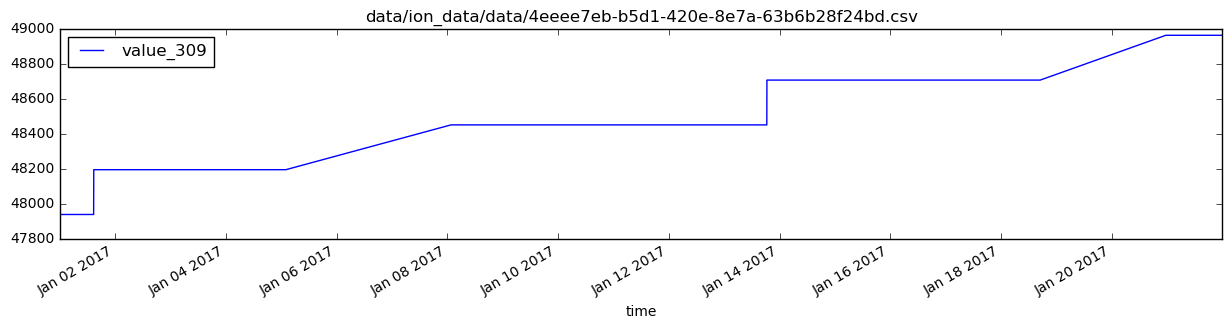

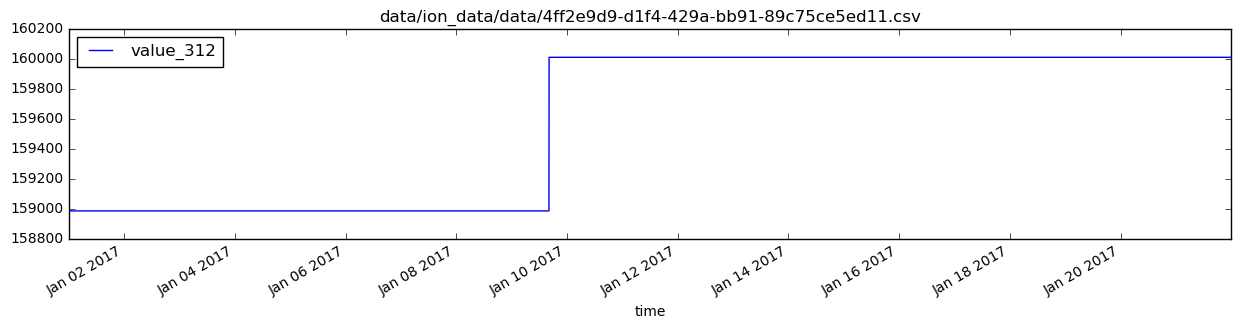

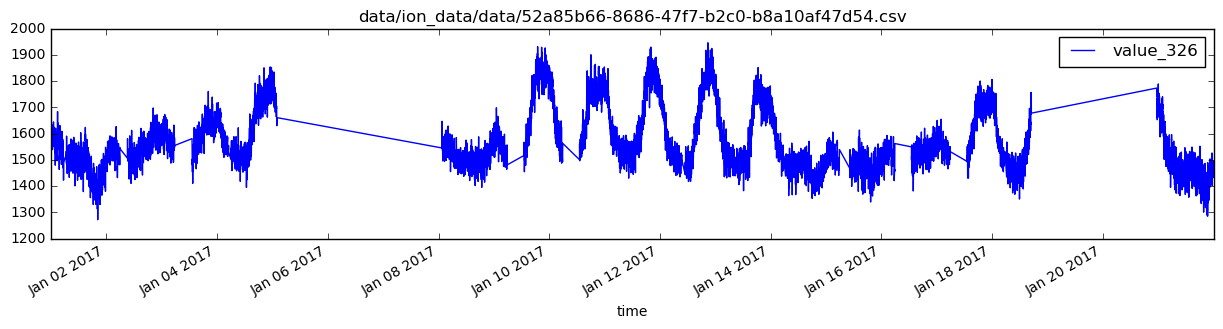

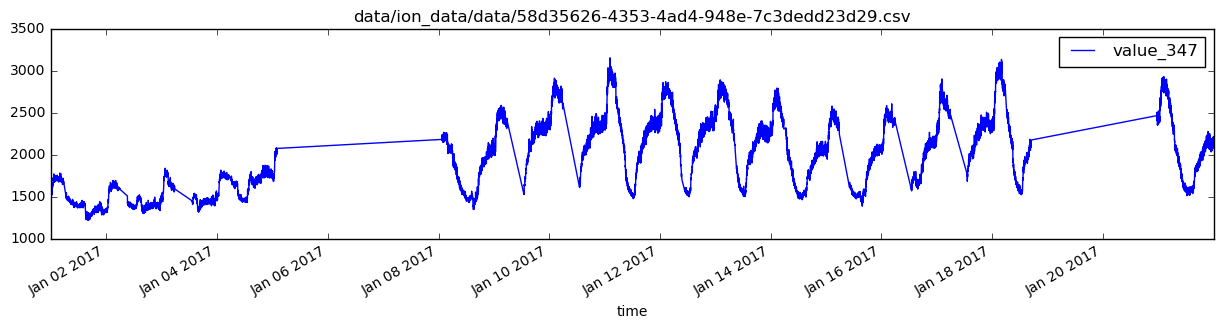

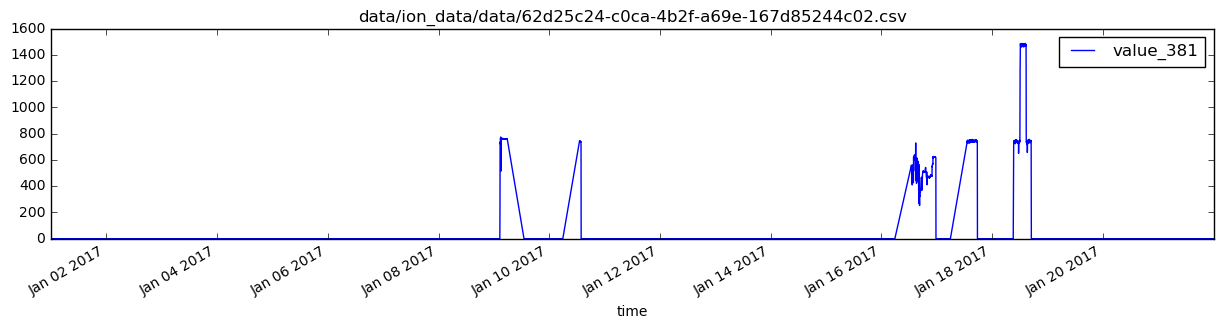

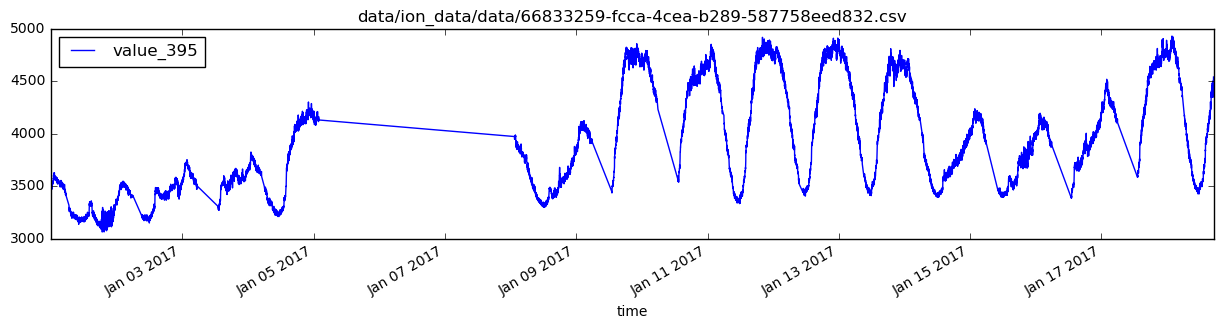

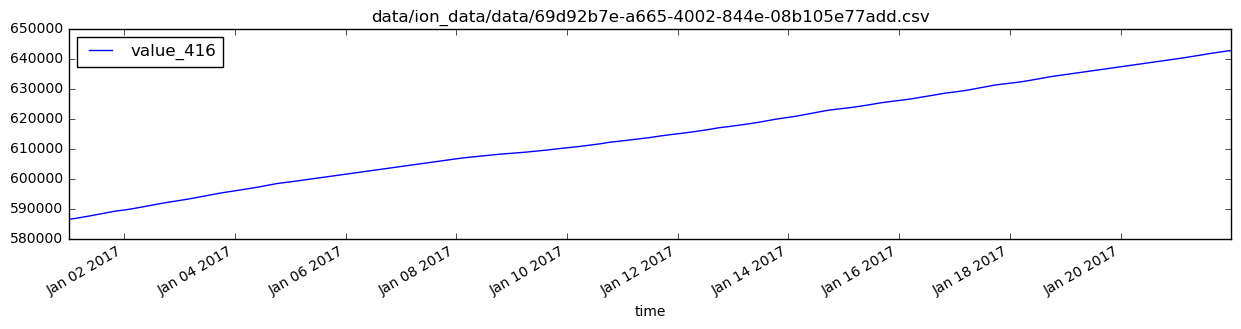

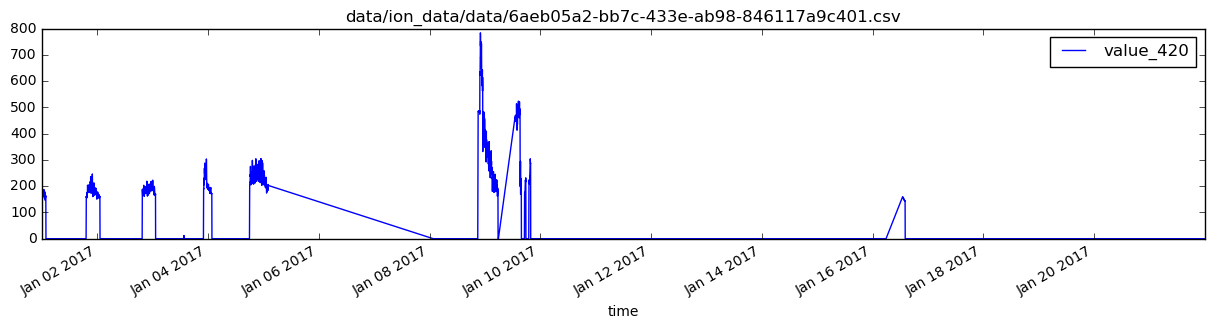

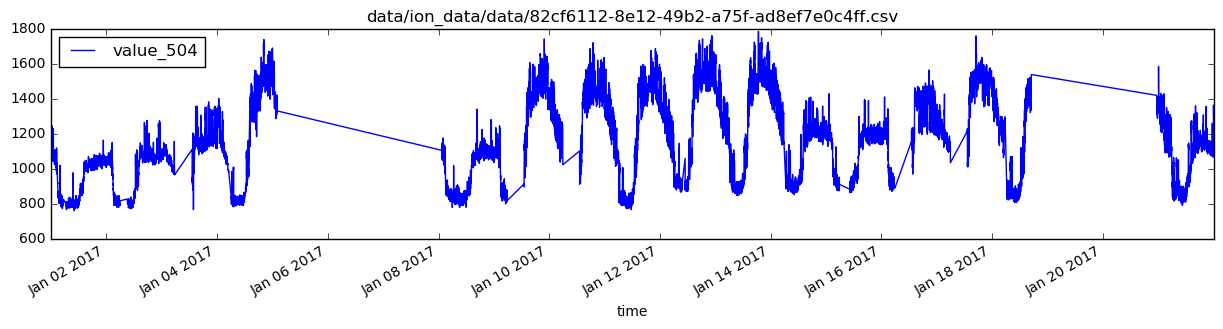

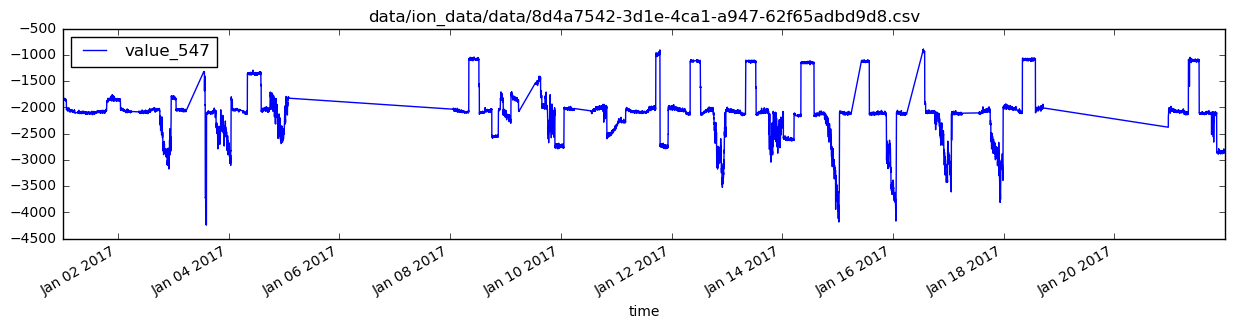

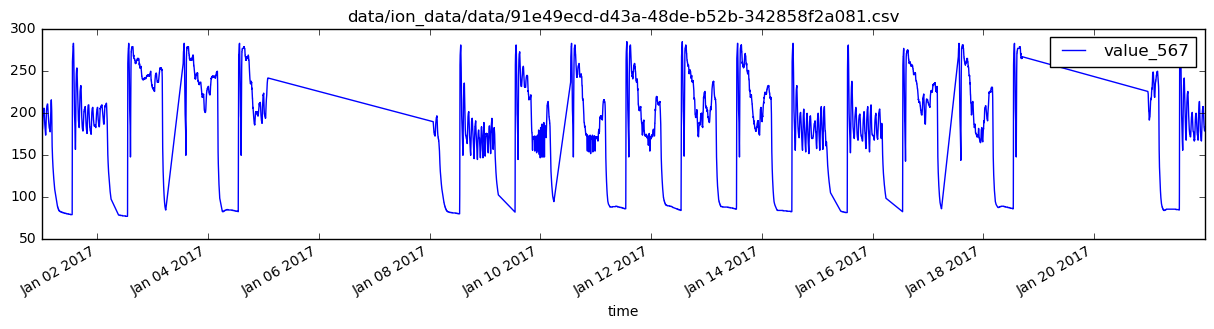

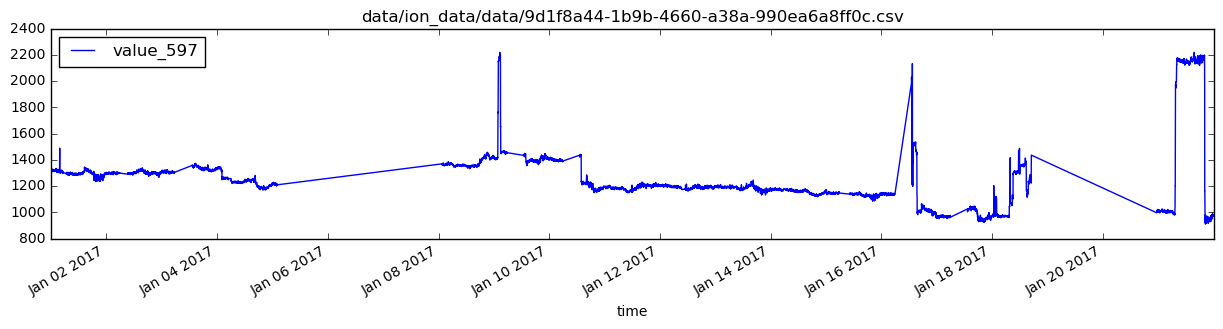

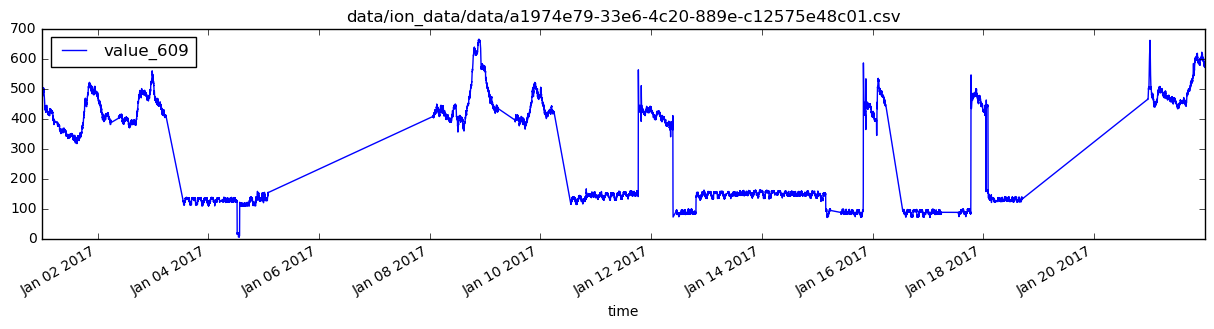

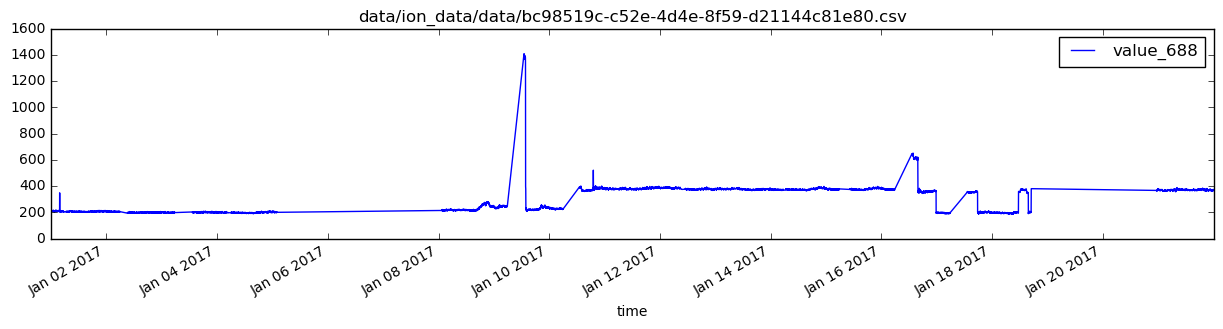

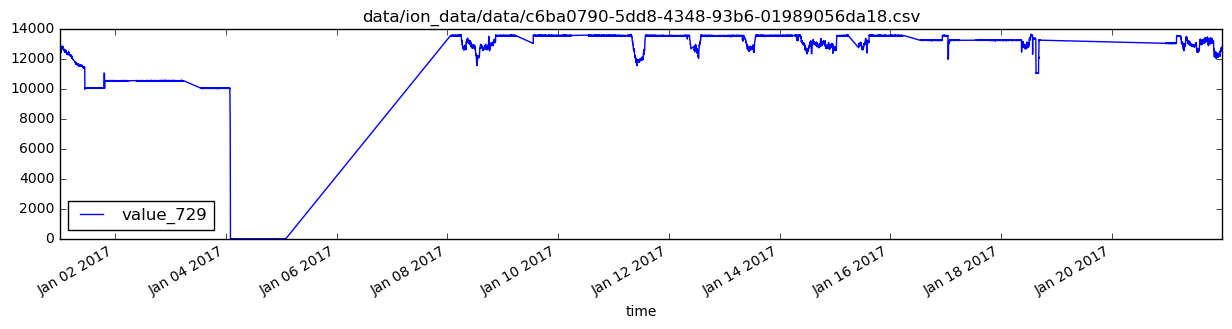

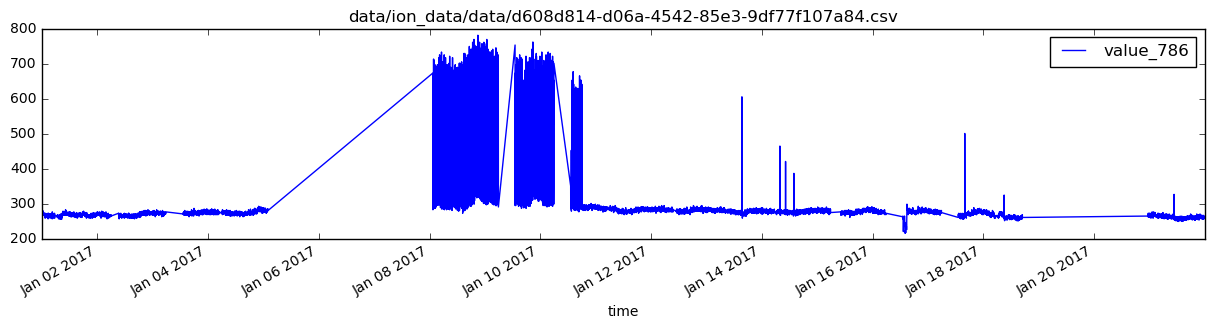

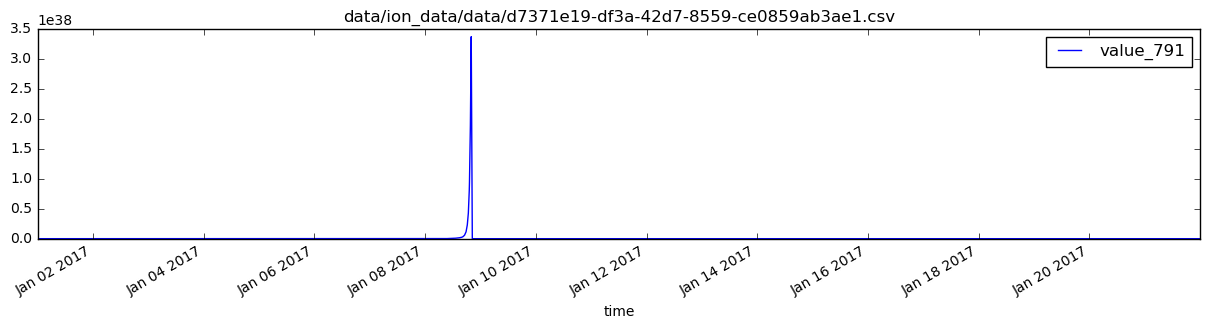

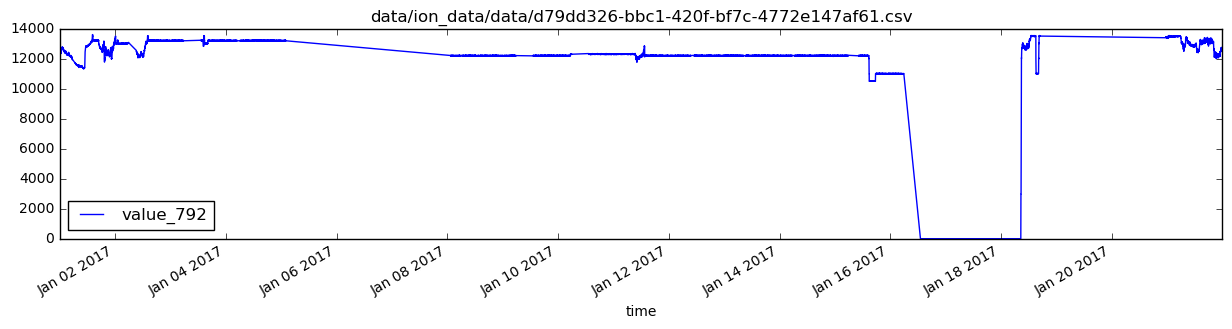

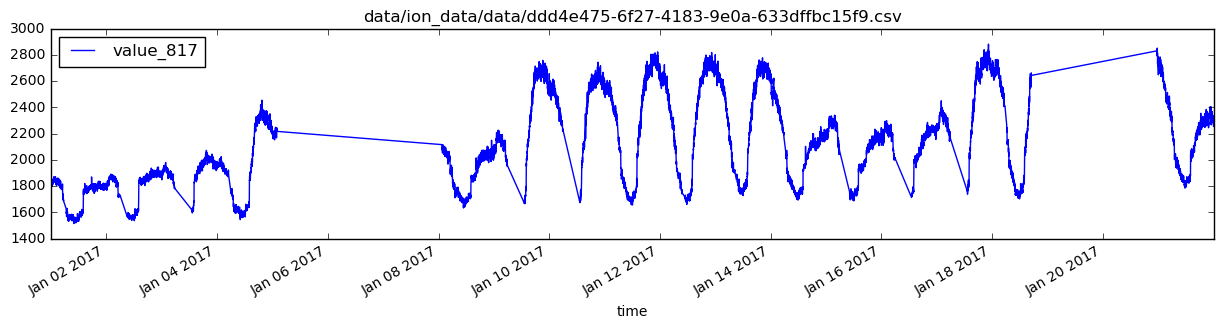

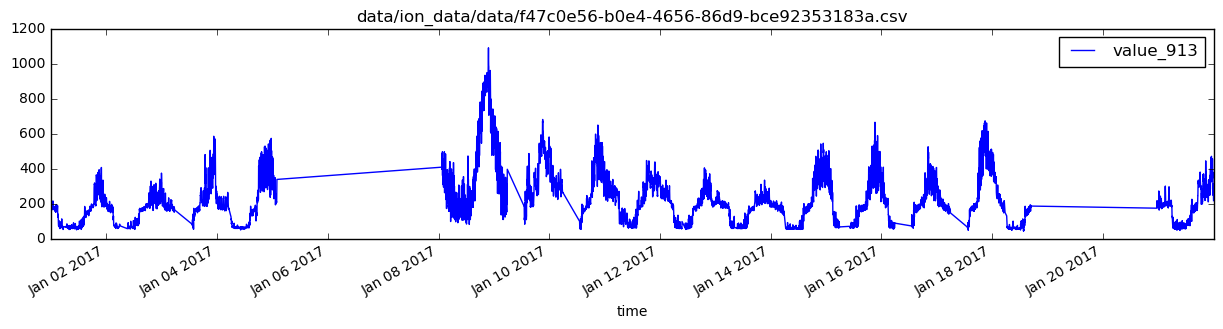

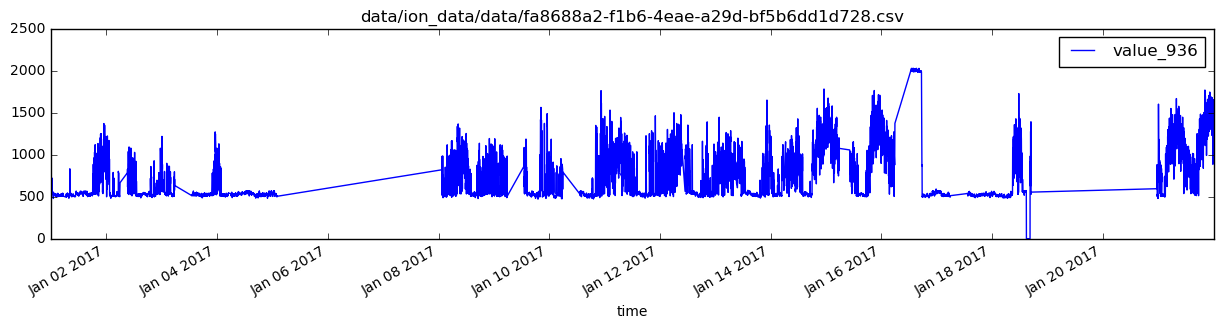

In [16]:
# Plot the sensors with nonzero model coefficients
for idx in np.nonzero(clf.coef_)[0]:
    print ion_files[idx]
    ion_df = pd.read_csv(ion_files[idx], header=None, names=['time', 'value_' + str(idx)])
    ion_df['time'] = pd.to_datetime(ion_df['time'])
    ion_df.plot(x='time', y='value_' + str(idx), figsize=(15, 3))
    plt.title(ion_files[idx])